# Random forest model on Spark

In this notebook, we use an ensemble regression model of weak learners (a random forest of decision trees, as implemented in Spark) to classify our pre-processed dataset. Specifically, we test the performance of our model with five different sets of features; then, we run a cross-validation on the one yielding the best results, to further optimize the obtained results.

In [1]:
from pyspark.ml import Pipeline, Transformer
from pyspark.ml.feature import VectorAssembler, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

import pyspark.sql.functions as F
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()


Bad key "text.kerning_factor" on line 4 in
/opt/anaconda3/envs/bigdatalab_cpu_202101/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.2/matplotlibrc.template
or from the matplotlib source distribution


## Input data parsing

In [2]:
inputPath = "/user/s291516/preprocessed/"
trainData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "trainData/").cache()
testData = spark.read.format("csv").option("header", True).option("inferSchema", True).load(inputPath + "testData/").cache()

## Evaluators definition

In [3]:
rmseEvaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="rmse")
r2Evaluator = RegressionEvaluator(predictionCol="prediction", labelCol="NumBikes+1", metricName="r2")
resultsDF = pd.DataFrame(columns=["Features", "Metric", "Value"])

## Label mapper definition

For prediction purposes, we are going to use the "diff" version of the features as produced in the data preprocessing notebook. The `LabelMapper` transformer will be used to translate back the "diff" prediction to a full prediction, obtained by summing the obtained prediction to the value of the `NumBikes` attribute.

In [4]:
class LabelMapper(Transformer):
    def _transform(self, inputDF):
        return inputDF.withColumn("prediction", F.col("prediction") + F.col("NumBikes"))

## Solution #1: only numerical features

In our first solution, we use only the numerical features exposed by our dataset (`NumBikesDiff-3`, `NumBikesDiff-2`, `NumBikesDiff-1`, `NumBikesDiff` and `NumBikes`) to predict the value of `NumBikesDiff+1`.

In [5]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes"], outputCol="features"),
    RandomForestRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

Analyzing the distribution of feature importance estimation with respect to the base learner case, we observe that the usage of an ensemble method "empowers" also other features which did not bring any information gain in the model.

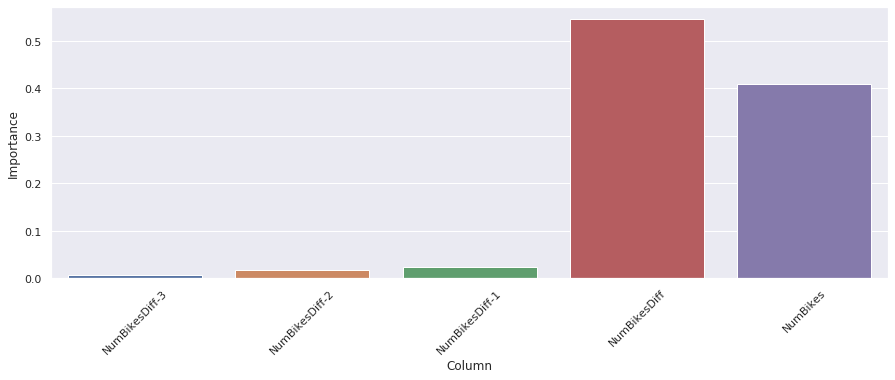

In [6]:
importanceDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Importance": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=importanceDF, x="Column", y="Importance", ax=ax)
ax.set_xticklabels(labels=importanceDF["Column"], rotation=45);

With respect to the standard decision tree case, the evaluation metrics do not change much (actually, they are slightly worse).

In [7]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Only numerical", "Metric": "RMSE", "Value": rmse},
    {"Features": "Only numerical", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4361275747620872
R2: 0.9666631427899344


## Solution #2: simple categorical features

In the second solution, we enlarge the feature space by adding the values categorical features (the hour, the day of the week, and the zone of the station) into the model. Note that in this case we do not need to previously encode our features (for example, using one-hot encoding): decision trees indeed do not regress directly on any features; rather, they use them to design proper split values, and in this sense it does not matter if the feature is numerical or categorical.

In [8]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone"
    ], outputCol="features"),
    RandomForestRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

In terms of feature importance, also in this case we observe some weight given also to other features (such as `NumBikesDiff-2`), with respect to the model comprised of a single decision tree.

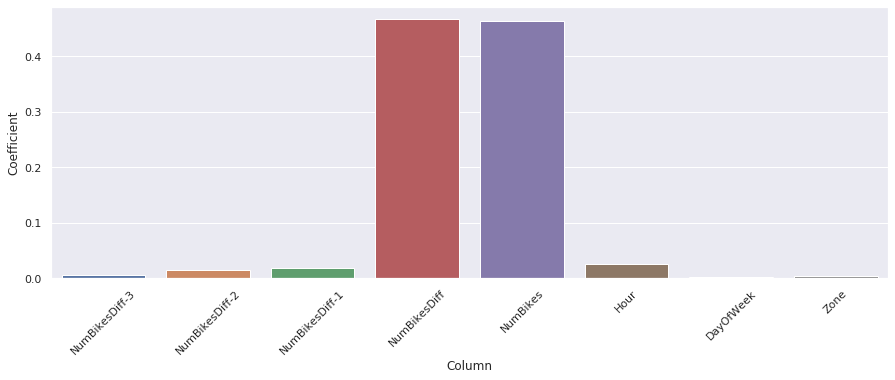

In [9]:
coefficientsDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Coefficient": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=coefficientsDF, x="Column", y="Coefficient", ax=ax)
ax.set_xticklabels(labels=coefficientsDF["Column"], rotation=45);

This features combination however does not seem to be really ideal for our purposes. Not only the evaluated metrics are worse than in solution #1, but they are also worse than the ones computed for the same set of features in the single tree model.

In [10]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Categorical OH", "Metric": "RMSE", "Value": rmse},
    {"Features": "Categorical OH", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4383025128117564
R2: 0.9665620925721197


## Solution #3: disjoint, effect-encoded categorical features

In the third solution, we use the effect-encoded version of our categorical features, considering only the "disjoint" ones (i.e., we consider separately the effect of the hour, day of the week, and zone of the station).

In [11]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "AvgByHour", "AvgByWeekday", "AvgByZone"
    ], outputCol="features"),
    RandomForestRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

Similar considerations on features importances may be done also in this case, with the random forest apparently favoring the "spread" of relevance on more features.

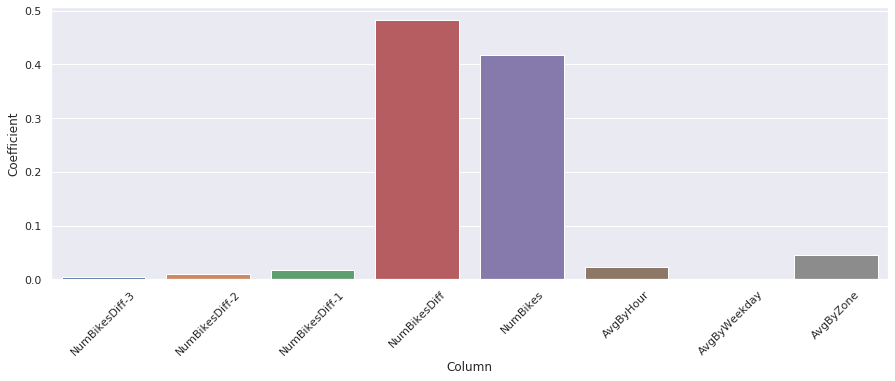

In [12]:
coefficientsDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Coefficient": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=coefficientsDF, x="Column", y="Coefficient", ax=ax)
ax.set_xticklabels(labels=coefficientsDF["Column"], rotation=45);

The resulting model again performs slightly worse than the corresponding decision tree.

In [13]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Disjoint effect", "Metric": "RMSE", "Value": rmse},
    {"Features": "Disjoint effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4358463071973073
R2: 0.9666761996500657


## Solution #4: combined, effect-encoded categorical features

Here, we consider a solution in which we use all the available numerical features, plus the joint average computed considering all the categorical values at once.

In [14]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=["NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes", "AvgCombined"], outputCol="features"),
    RandomForestRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

Also in the random forest case, a very significant contribution to the information gain is given by the aggregate value of `AvgCombined`, which now ranks as the third feature by importance, after `NumBikesDiff` and `NumBikes`.

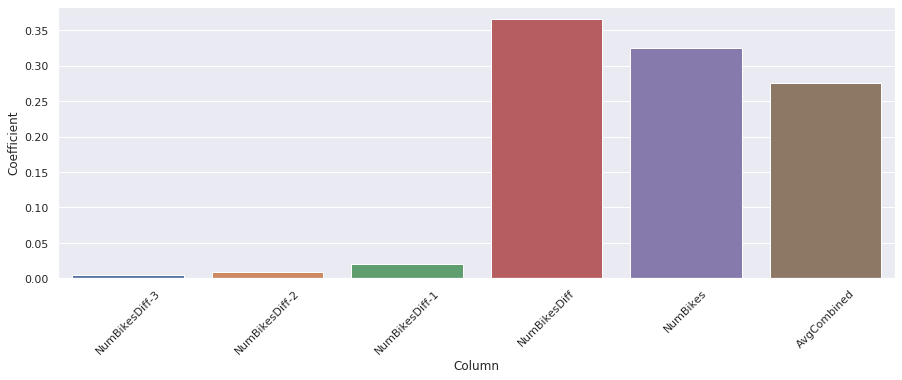

In [15]:
coefficientsDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Coefficient": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=coefficientsDF, x="Column", y="Coefficient", ax=ax)
ax.set_xticklabels(labels=coefficientsDF["Column"], rotation=45);

In terms of test metrics, this solution is the first one to present better performance with respect to the corresponding, single decision tree model, with reduced RMSE and increased R2.

In [16]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "Combined effect", "Metric": "RMSE", "Value": rmse},
    {"Features": "Combined effect", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4289913830529355
R2: 0.9669936247666088


## Solution #5: putting all together

Finally, we test a solution in which all the aforementioned features are fed to the learning algorithm.

In [17]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ], outputCol="features"),
    RandomForestRegressor(labelCol="NumBikesDiff+1", seed=42),
    LabelMapper()
])

model = pipeline.fit(trainData)

Again, adding features over the ones used in solution #4 has a very limited effect; the most important features remain the `NumBikesDiff`, `AvgCombined` (which now becomes second by importance) and `NumBikes`. As it has been observed multiple times in these experiments, there is also a portion of the overall importance that gets attributed also to other features, whereas in the single tree case those were practically all zero.

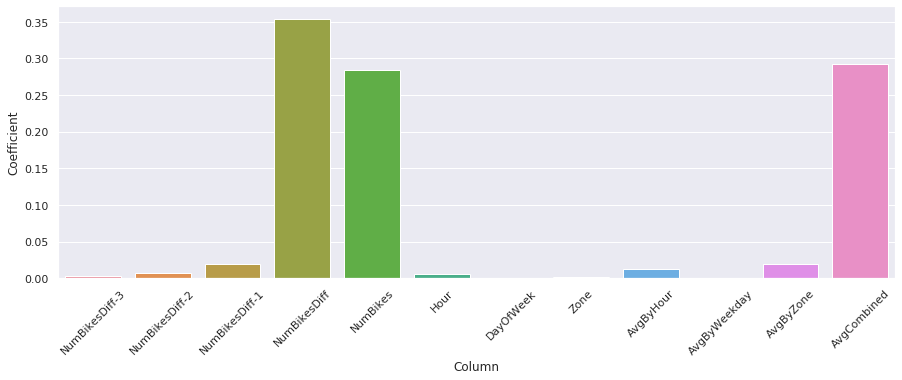

In [18]:
coefficientsDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Coefficient": model.stages[1].featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=coefficientsDF, x="Column", y="Coefficient", ax=ax)
ax.set_xticklabels(labels=coefficientsDF["Column"], rotation=45);

Oddly, this model is however less precise than the one in solution #4 (and the one using the single decision tree with the same set of features), as reflected by the metrics below.

In [19]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "All", "Metric": "RMSE", "Value": rmse},
    {"Features": "All", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.431420500106554
R2: 0.9668813154901715


## Hyperparameter optimization

For solution #5, we run an optimization procedure to determine the best value for the parameters of the regression model, so to increase even further the performance of our model. To do so, we used the parameter grid defined in the cell below, in which we tested different values of all the parameters of Spark's decision tree model; then, we fitted a `Pipeline` object using a `CrossValidator` stage (the number of CV folds was set to its default value of 3).

In [20]:
rf = RandomForestRegressor()
grid = ParamGridBuilder() \
    .baseOn({rf.labelCol: "NumBikesDiff+1", rf.seed: 42}) \
    .addGrid(rf.maxDepth, [5, 10]) \
    .addGrid(rf.minInstancesPerNode, [1, 10, 20]) \
    .addGrid(rf.minInfoGain, [0, 0.1, 0.2]) \
    .addGrid(rf.subsamplingRate, [1, 0.75]) \
    .addGrid(rf.numTrees, [20, 50, 100]) \
    .build()

In [21]:
pipeline = Pipeline(stages=[
    VectorAssembler(inputCols=[
        "NumBikesDiff-3", "NumBikesDiff-2", "NumBikesDiff-1", "NumBikesDiff", "NumBikes",
        "Hour", "DayOfWeek", "Zone",
        "AvgByHour", "AvgByWeekday", "AvgByZone", "AvgCombined"
    ], outputCol="features"),
    CrossValidator(estimator=rf, estimatorParamMaps=grid, evaluator=RegressionEvaluator(predictionCol="prediction", labelCol="NumBikesDiff+1", metricName="rmse")),
    LabelMapper()
])

model = pipeline.fit(trainData)

The overall best model is characterized by the parameters below.

In [22]:
print("Best model params:")
print("\n".join([f"- {x[0].name}: {x[1]}" for x in model.stages[1].bestModel.extractParamMap().items()]))

Best model params:
- cacheNodeIds: False
- checkpointInterval: 10
- featureSubsetStrategy: auto
- featuresCol: features
- impurity: variance
- labelCol: NumBikesDiff+1
- maxBins: 32
- maxDepth: 10
- maxMemoryInMB: 256
- minInfoGain: 0.0
- minInstancesPerNode: 1
- numTrees: 100
- predictionCol: prediction
- seed: 42
- subsamplingRate: 1.0


Similarly to the single tree model, with respect to the unoptimized case, the optimized solution increases even more the spread of importance over multiple features, while the most important attributes remain `NumBikesDiff`, `NumBikes` and `AvgCombined`.

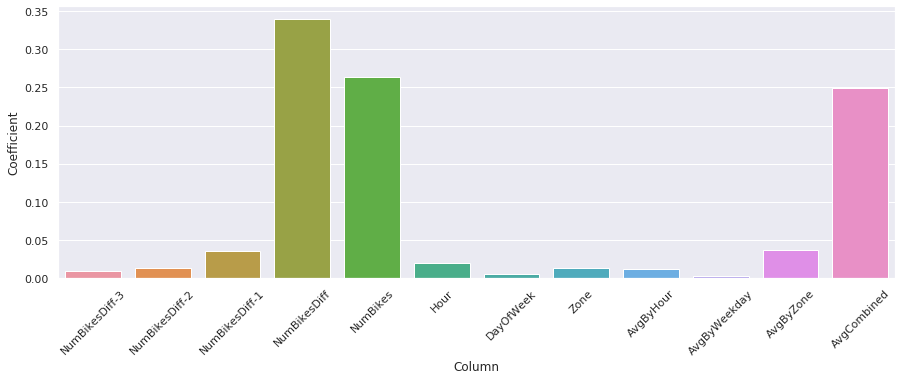

In [23]:
coefficientsDF = pd.DataFrame({
    "Column": model.stages[0].getInputCols(),
    "Coefficient": model.stages[1].bestModel.featureImportances
})

fig, ax = plt.subplots(figsize=(15, 5))
sns.barplot(data=coefficientsDF, x="Column", y="Coefficient", ax=ax)
ax.set_xticklabels(labels=coefficientsDF["Column"], rotation=45);

Applying the optimized model on our test data, we observe a significant improvement of the evaluation metrics, greater than any difference we were able to observe by any enrichment of the feature space performed above and slightly better than the single tree case.

In [24]:
predictedTestData = model.transform(testData)

rmse = rmseEvaluator.evaluate(predictedTestData)
print("RMSE:", rmse)

r2 = r2Evaluator.evaluate(predictedTestData)
print("R2:", r2)

resultsDF = resultsDF.append([
    {"Features": "All (CV)", "Metric": "RMSE", "Value": rmse},
    {"Features": "All (CV)", "Metric": "R2", "Value": r2}
], ignore_index=True)

RMSE: 1.4171327434503034
R2: 0.9675391656719607


## Comparison of the results

The two graphs below summarize the evolution of the RMSE and R2 metrics for the different sets of features tested.

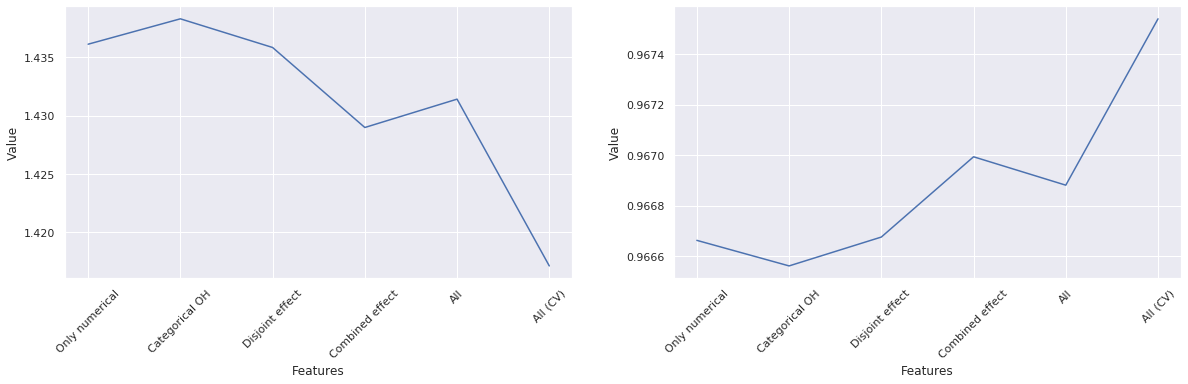

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(20, 5))
sns.lineplot(data=resultsDF[resultsDF["Metric"] == "RMSE"], x="Features", y="Value", ax=ax[0])
sns.lineplot(data=resultsDF[resultsDF["Metric"] == "R2"], x="Features", y="Value", ax=ax[1])
ax[0].set_xticklabels(labels=resultsDF[resultsDF["Metric"] == "RMSE"]["Features"], rotation=45)
ax[1].set_xticklabels(labels=resultsDF[resultsDF["Metric"] == "R2"]["Features"], rotation=45);